# Generative Adversarial Networks (GANs) on MNIST Dataset: From Scratch to Synthesis

## Introduction

Welcome to this deep dive into Generative Adversarial Networks (GANs). In this notebook, we aim to implement GANs from scratch, using the MNIST dataset as our playground. While GANs have a myriad of applications, from art creation to data augmentation, our primary focus will be on understanding the architecture and mechanisms underlying these fascinating models.

### What are GANs?

![GANs](./assets/GANs.png)

Generative Adversarial Networks (GANs) are a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. They are a type of generative model, a model that learns to generate new data instances that resemble the training data. GANs are composed of two neural networks, a generator and a discriminator, that compete against each other in a zero-sum game framework. The generator tries to fool the discriminator by generating fake data instances, while the discriminator tries to distinguish between the real and fake data instances. The generator is trained to fool the discriminator, and the discriminator is trained to not be fooled by the generator. This competition between the two networks is what gives GANs their name.

### Why GANs?

GANs are one of the most exciting advancements in the field of machine learning and artificial intelligence in the last decade. They provide a framework for training generative models that can create data instances statistically similar to some input data. In other words, they allow us to generate new data that is similar but not identical to the data we have.

### What Will We Learn?

- Fundamentals of Generative Adversarial Networks
- Custom Data Processing on the MNIST dataset
- Creating Models from Scratch
- Implementing Cost Functions
- Training the GAN
- Evaluating the Results

## Dataset Used

We'll use the MNIST dataset, comprising hand-written digits, to train our GAN model. This dataset is commonly used for practicing various machine learning algorithms and is readily available through PyTorch's torchvision package.

As secondary data, we'll also use the FashionMNIST dataset, which is also available through torchvision. This dataset is similar to MNIST, but instead of hand-written digits, it contains images of clothing items.

## Authors

- [Joaquin Vigna](https://github.com/BRJoaquin)

> **Note**: This notebook is also a part of an academic assignment; however, it is designed to be a comprehensive guide. Feel free to reach out if you have suggestions for improvements or find errors.

## References

- Original GAN Paper: [Generative Adversarial Nets](https://arxiv.org/abs/1406.2661)
- MNIST Dataset: [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist/)
- FashionMNIST Dataset: [Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms](https://arxiv.org/abs/1708.07747)

## Imports

In this notebook we are going to use conda to install the required packages. 
You can find the instructions to install conda [here](https://docs.conda.io/projects/conda/en/latest/user-guide/install/), and the dependencies are listed in the `environment.yml` file.

In [1]:
# PyTorch is an open-source machine learning library used for a variety of tasks,
# but primarily for training deep neural networks.
import torch

# nn is a sub-module in PyTorch that contains useful classes and functions to build neural networks.
import torch.nn as nn

# F is a sub-module in PyTorch that contains useful functions for building neural networks.
import torch.nn.functional as F

# DataLoader is a PyTorch utility for loading and batching data efficiently.
from torch.utils.data import DataLoader, Subset

# torchvision contains various utilities, pre-trained models, and datasets specifically
# geared towards computer vision tasks.
import torchvision

# datasets are a set of common datasets used for computer vision tasks.
# transforms are a set of common image transformations that are often required when
# working with image data.
from torchvision import datasets, transforms

# ImageFolder is a utility for loading images directly from a directory structure where
# each sub-directory represents a different class.
from torchvision.datasets import ImageFolder

# random_split is a utility function to randomly split a dataset into non-overlapping
# new datasets of given lengths.
from torch.utils.data import random_split

# SummaryWriter is a PyTorch utility for logging information to be displayed in TensorBoard.
from torch.utils.tensorboard import SummaryWriter

# summary is a PyTorch utility for displaying the summary of a PyTorch model.
from torchinfo import summary

# tqdm is a Python library that adds a progress bar to an iterable object.
from tqdm import tqdm

# Matplotlib is a plotting library that is useful for visualizing data, plotting graphs, etc.
import matplotlib.pyplot as plt

# NumPy is a library for numerical operations and is especially useful for array and
# matrix computations.
import numpy as np

# PIL is a library for image processing.
from PIL import Image

# os is a Python module that provides a portable way of using operating system dependent
import os

# time is a module that provides various time-related functions.
import time

# random is a module that implements pseudo-random number generators for various distributions.
import random

# accuracy_score computes the accuracy classification score.
# confusion_matrix computes confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

# itertools is a module that provides various functions that work on iterators to produce
from itertools import product

# math is a module that provides access to the mathematical functions.
import math

# Counter is a dictionary subclass for counting hashable objects.
from collections import Counter

## Checking CUDA Availability

In deep learning projects, it's common to leverage the power of GPUs for computation. CUDA is a parallel computing platform that allows us to use the GPU for these intensive calculations. The following code snippet checks if CUDA is available on the machine. If CUDA is available, it sets the device to "cuda"; otherwise, it falls back to using the CPU.

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

Using device: cuda


## Setting the Seed

Setting the seed ensures that the results are reproducible. This is important for debugging and testing purposes.

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Exploration

Before diving into the complexities of Generative Adversarial Networks, it's essential to have a solid understanding of the dataset we'll be working with. The MNIST dataset contains 28x28 grayscale images of handwritten digits (0 through 9).

### Objectives

1. Load the MNIST dataset from PyTorch's `torchvision` package.
2. Visualize some sample images from the dataset.
3. Examine the distribution of different classes (digits 0-9) in the dataset.
4. Understand basic statistics and properties of the dataset like mean, standard deviation, etc.

### Loading the Data

The MNIST dataset can be easily loaded using the `torchvision.datasets` package from PyTorch. It provides an easy-to-use API for downloading and accessing the dataset.

In [4]:
def get_mnist_data_loader(transform, batch_size=32):
    # Download and load the MNIST data
    train_data = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )
    test_data = datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )
    combined_data = torch.utils.data.ConcatDataset([train_data, test_data])
    # DataLoader allows us to batch and shuffle the data
    train_loader = DataLoader(
        combined_data, batch_size=batch_size, shuffle=True, drop_last=True
    )
    return train_loader

The FashionMNIST dataset is a drop-in replacement for the MNIST dataset. It has the same number of training and test examples and the same image size and structure. The only difference is that the images are of fashion items rather than handwritten digits. We'll use the FashionMNIST dataset in the next notebook.

In [5]:
def get_fashion_data_loader(transform, batch_size=32):
    # Download and load the MNIST data
    train_data = datasets.FashionMNIST(
        root="data", train=True, download=True, transform=transform
    )
    test_data = datasets.FashionMNIST(
        root="data", train=False, download=True, transform=transform
    )
    combined_data = torch.utils.data.ConcatDataset([train_data, test_data])
    # DataLoader allows us to batch and shuffle the data
    train_loader = DataLoader(
        combined_data, batch_size=batch_size, shuffle=True, drop_last=True
    )
    # test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    return train_loader

### Sample Images

Visualizing data samples is a powerful way to get a sense of what you're working with. This sub-section will display some example images from the MNIST and FashionMNIST datasets.

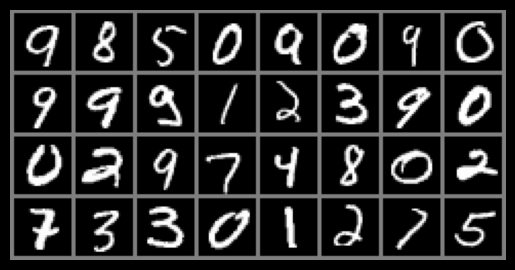

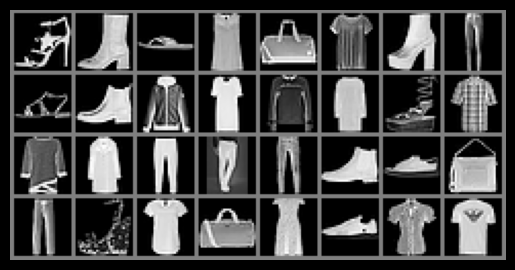

In [6]:
# Function to display an image grid
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


def show_sample(loader, number_of_real_samples=32):
    if number_of_real_samples > 32:
        print("Number of samples should be less or equal than 32")
        number_of_real_samples = 32
    # Get one batch of training images
    dataiter = iter(loader)
    images, labels = next(dataiter)
    # Display the images in a grid
    imshow(torchvision.utils.make_grid(images[:number_of_real_samples]))


transformer = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)

mnist_loader = get_mnist_data_loader(transform=transformer)
fashion_loader = get_fashion_data_loader(transform=transformer)

show_sample(mnist_loader)
show_sample(fashion_loader)

### Class Distribution

Understanding the distribution of different classes within the dataset is crucial. This can help us assess whether the dataset is balanced or skewed, which in turn informs model design and evaluation metrics.

Class Distribution: {6: 6873, 7: 7292, 1: 7877, 5: 6312, 3: 7140, 0: 6901, 4: 6824, 9: 6954, 2: 6989, 8: 6822}


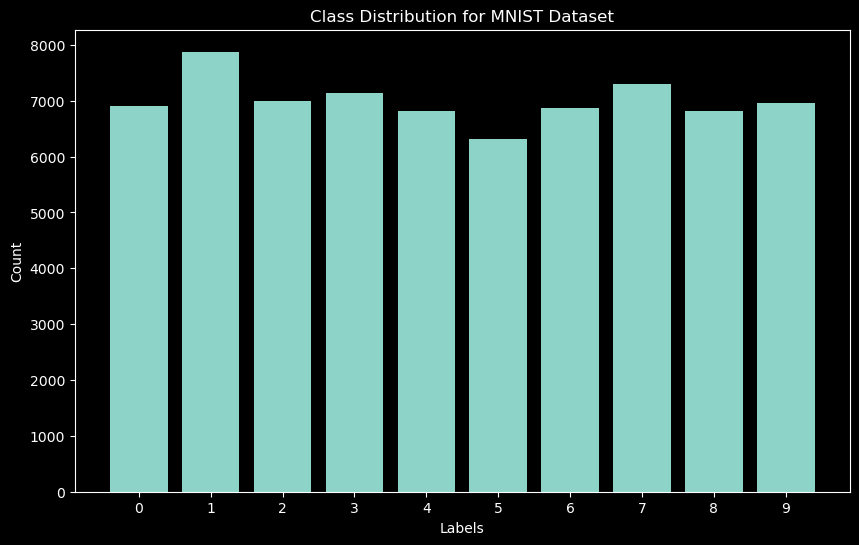

Class Distribution: {2: 6999, 9: 6997, 3: 6999, 1: 7000, 0: 6998, 5: 6999, 8: 6998, 4: 6998, 7: 6999, 6: 6997}


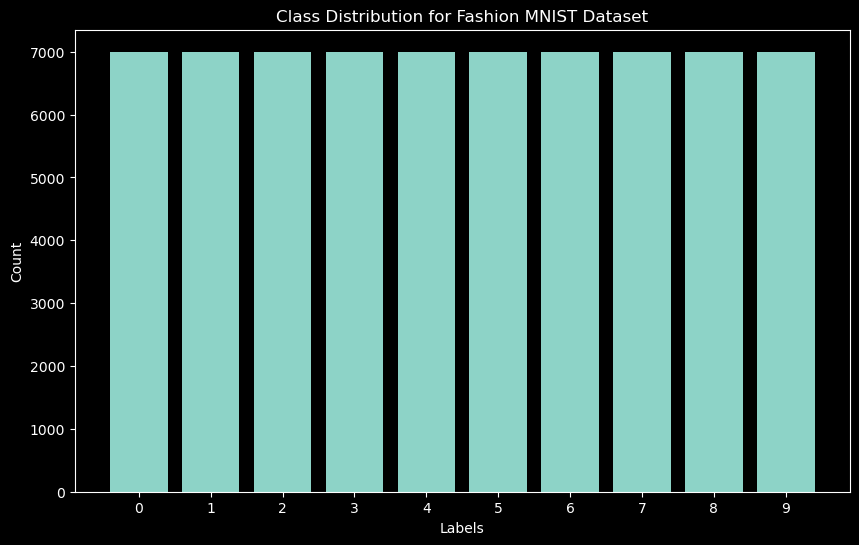

In [7]:
def class_distribution(loader, name):
    # Initialize a Counter object
    label_count = Counter()

    # Loop through the dataset to count the labels
    for _, labels in loader:
        label_count.update(labels.numpy())

    # Convert the Counter object to a dictionary for easier manipulation
    label_count_dict = dict(label_count)

    # Print the label distribution
    print("Class Distribution:", label_count_dict)

    labels = list(label_count_dict.keys())
    counts = list(label_count_dict.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(f"Class Distribution for {name} Dataset")
    plt.xticks(labels)
    plt.show()


class_distribution(mnist_loader, "MNIST")
class_distribution(fashion_loader, "Fashion MNIST")

After examining the class distribution of the MNIST dataset, it's evident that the classes are well-balanced. Each digit from 0 to 9 appears in roughly the same number of instances in the dataset. Therefore, we don't need to worry about class imbalance affecting our model's performance.

## GAN Training Auxiliary Functions

### generate_fake_images

- **Role**: Generates a set of fake images using the generator.
- **Parameters**:
  - `generator`: The generator model.
  - `noise_size`: Size of the latent vector or noise.
  - `number_of_fake_samples`: Number of fake images to generate (default: 8).

In [8]:
def generate_fake_images(generator, noise_size, number_of_fake_samples=8):
    with torch.no_grad():
        # Create a batch of latent vectors (noise)
        z = torch.randn(number_of_fake_samples, noise_size).to(device)
        # Generate images from the latent vector z
        fake_images = generator(z)
        # Move the tensor from GPU to CPU and detach it from the computation graph
        fake_images = fake_images.cpu().detach()
        grid_images = torchvision.utils.make_grid(
            fake_images, nrow=8
        )  # Arrange the images into a grid with 8 columns
        # Use the adapted imshow function
        imshow(grid_images)

### train_discriminator

- **Role**: Trains the discriminator model for K iterations.
- **Parameters**:
  - `discriminator`, `real_images`, `fake_images`, `criterion`, `optimizer_d`, etc.
  - `do_smoothing`: Flag to determine if label smoothing is applied.
  - `do_instance_noise`: Flag to determine if instance noise is added.

#### Instance Noise and Label Smoothing

- **Role**: Add regularization to stabilize training.
  - `add_instance_noise`: Adds noise to real and fake images.
  - `smooth_positive_labels`: Applies label smoothing to positive labels.
  - `smooth_negative_labels`: Applies label smoothing to negative labels.
- **Parameters**:
  - For `add_instance_noise`: `std` determines the noise standard deviation.
  - For label smoothing functions: Input tensor `y`.

> While the original GAN paper did not incorporate techniques like Instance Noise and Label Smoothing, they have been introduced in subsequent research and practical implementations as ways to improve GAN stability and performance. These techniques often act as regularizers, helping to ensure smoother gradients and more robust training. In the context of this project, the inclusion of Instance Noise and Label Smoothing came as a recommendation from my tutor, and it aligns with the set of best practices compiled by the AI community for training stable GANs. For more insights and a collection of GAN hacks, you can refer to [this repository](https://github.com/soumith/ganhacks) maintained by Soumith Chintala.

In [9]:
def add_instance_noise(images, std=0.01):
    return images + torch.randn_like(images) * std


def smooth_positive_labels(y):
    return y - 0.3 + (torch.rand(y.size()).to(device) * 0.3)  # 0.7 to 1.0


def smooth_negative_labels(y):
    return y + torch.rand(y.size()).to(device) * 0.3  # 0.0 to 0.3


def train_discriminator(
    discriminator,
    real_images,
    fake_images,
    criterion,
    optimizer_d,
    k,
    batch_size,
    do_smoothing=False,
    do_instance_noise=False,
):
    for _ in range(k):
        # Discriminator training
        optimizer_d.zero_grad()

        if do_instance_noise:
            real_images = add_instance_noise(real_images)
            fake_images = add_instance_noise(fake_images)

        # Real images
        labels_real = torch.ones(real_images.size(0), 1).to(device)
        if do_smoothing:
            labels_real = smooth_positive_labels(labels_real)

        outputs_real = discriminator(real_images)

        loss_real = criterion(outputs_real, labels_real)

        labels_fake = torch.zeros(batch_size, 1).to(device)
        if do_smoothing:
            labels_fake = smooth_negative_labels(labels_fake)

        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, labels_fake)

        # Combine losses and update Discriminator
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

    return loss_d

### train_generator

- **Role**: Trains the generator model for one iteration.
- **Parameters**:
  - `discriminator`, `fake_images`, `criterion`, `optimizer_g`, etc.

In [10]:
def train_generator(discriminator, fake_images, criterion, optimizer_g, batch_size):
    # Generator training
    optimizer_g.zero_grad()

    outputs = discriminator(fake_images)
    labels = torch.ones(batch_size, 1).to(device)

    # Update Generator
    loss_g = criterion(outputs, labels)
    loss_g.backward()
    optimizer_g.step()
    return loss_g

### train_model

- **Role**: Manages the overall training process of both generator and discriminator.
- **Parameters**:
  - `discriminator`, `generator`, training dataset `train_loader`, `criterion`, optimizers, etc.
  - `do_smoothing_label`: Flag to determine if label smoothing is applied.
  - `do_instance_noise`: Flag to determine if instance noise is added.
  - `log_samples`: Flag to determine if fake samples should be logged/displayed.
  - `log_interval`: Epoch interval for logging/displaying fake samples.

In [11]:
def train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=False,
    do_instance_noise=False,
    log_samples=False,
    log_interval=10,
):
    losses_d = []
    losses_g = []
    # Training loop
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            for _, (real_images, _) in enumerate(train_loader):
                # Move tensors to the device
                real_images = real_images.to(device)
                noise = torch.randn(batch_size, noise_size).to(device)
                fake_images = generator(noise).to(device)

                loss_d = train_discriminator(
                    discriminator,
                    real_images,
                    fake_images,
                    criterion,
                    optimizer_d,
                    k,
                    batch_size,
                    do_smoothing=do_smoothing_label,
                    do_instance_noise=do_instance_noise,
                )
                loss_g = train_generator(
                    discriminator, fake_images, criterion, optimizer_g, batch_size
                )

            pbar.update(1)
            pbar.set_postfix(
                {"discriminator_loss": loss_d.item(), "generator_loss": loss_g.item()},
                refresh=True,
            )

            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

            if log_samples and epoch % log_interval == 0:
                generate_fake_images(generator, noise_size)

    return losses_d, losses_g

In [12]:
# Plot the losses
def plot_losses(losses_d, losses_g, do_avg=False, avg_window=10):
    if do_avg:
        losses_d = np.convolve(losses_d, np.ones(avg_window), "valid") / avg_window
        losses_g = np.convolve(losses_g, np.ones(avg_window), "valid") / avg_window
    plt.figure(figsize=(10, 6))
    plt.plot(losses_d, label="Discriminator loss")
    plt.plot(losses_g, label="Generator loss")
    plt.legend()
    plt.title("Losses")
    plt.show()

## Baseline Solution

### Building a Baseline Discriminator Model

#### Architecture

The Discriminator is a neural network that aims to classify whether a given image is real (from the dataset) or fake (generated by the Generator). In this enhanced model, we'll incorporate Convolutional Neural Network (CNN) layers to better capture the hierarchical features in images. The updated architecture will consist of the following layers:

1. **Convolutional Layer 1**: A 2D convolutional layer with 64 filters and a kernel size of 3x3, followed by a ReLU activation function.
2. **Convolutional Layer 2**: Another 2D convolutional layer with 128 filters and a kernel size of 3x3, followed by a ReLU activation function.
3. **Flatten**: A layer to flatten the output from the convolutional layers.
4. **Fully Connected Layers**: One hidden layer with 128 neurons, using a ReLU activation function.
5. **Output Layer**: A single neuron with a Sigmoid activation function to output the probability that the input image is real.

#### Objective and Loss Function

The objective of the Discriminator is derived from a [minimax](https://en.wikipedia.org/wiki/Minimax) two-player game as defined in the original [GAN paper](https://arxiv.org/pdf/1406.2661.pdf). The value function $V(D, G)$ for this game is:

$$ 
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)}[\log(1 - D(G(z)))] 
$$

This can be interpreted as maximizing the log-likelihood of correctly classifying both real and fake samples. In practical terms, this objective is implemented using binary cross-entropy loss, with the Discriminator aiming to output values close to 1 for real images and close to 0 for fake images.

#### Implementation

The model will be implemented using PyTorch. Given the objective and the architecture, the Discriminator will be trained using real images labeled as 1 and fake images labeled as 0. The inclusion of convolutional layers aims to improve its ability to distinguish between real and fake images effectively.


In [13]:
class BaseLineDiscriminator(nn.Module):
    def __init__(self, in_channels, img_size):
        super(BaseLineDiscriminator, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # Calculate the output dimension after conv and pooling layers
        self.calc_dim = lambda x: int(((x - 2) // 2 + 1) // 2)
        self.flat_dim = (
            128
            * self.calc_dim(self.calc_dim(img_size))
            * self.calc_dim(self.calc_dim(img_size))
        )

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 max pooling
        x = x.view(-1, self.flat_dim)  # flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # output between 0 and 1
        return x

### Building a Baseline Generator Model

#### Architecture

The Generator is a neural network designed to create synthetic data that resembles a real dataset. For image generation tasks, it employs a series of Transposed Convolutional Neural Network (DeconvNet) layers that help upscale a lower-dimensional input to a full-sized image. The architecture consists of the following layers:

1. **Fully Connected Layer**: Takes a noise vector (e.g., 100-dimensional) as input and maps it to a higher-dimensional space (256 * 7 * 7), setting the stage for the transposed convolutions.
2. **Transposed Convolutional Layer 1**: A 2D transposed convolutional layer with 128 filters and a kernel size of 3x3. It is followed by a ReLU activation function.
3. **Transposed Convolutional Layer 2**: Another 2D transposed convolutional layer with 64 filters and a kernel size of 3x3, also followed by a ReLU activation function.
4. **Output Layer**: A final 2D transposed convolutional layer with a single filter, having a kernel size of 3x3, with a Tanh activation function to output an image in a range between -1 and 1.

#### Objective and Loss Function

The objective of the Generator, in the context of a Generative Adversarial Network (GAN), is to generate data that is indistinguishable from real data by the Discriminator. Mathematically, the Generator aims to minimize the following function in a [minimax game](https://en.wikipedia.org/wiki/Minimax) against the Discriminator:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_{z}(z)}[\log(1 - D(G(z)))]
$$

In simple terms, the Generator wants to maximize the error of the Discriminator in classifying its output as fake. The loss function generally used is the binary cross-entropy loss.

> In the original GAN paper by Goodfellow et al., the generator's loss function is suggested as $\log(1 - D(G(z)))$, where $D(G(z))$ is the discriminator's output for generated data. This theoretically aligns with the GAN framework but in practice, it leads to weak gradients when $D(G(z))$ is small, slowing the generator's learning. Contrastingly, the common practice is to use $-\log D(G(z))$ for the generator’s loss. This change provides stronger gradients, especially during 
early training stages, facilitating more effective and stable learning. This modification exemplifies the practical adjustments often made to theoretical models to address real-world training challenges in GANs.


#### Implementation

The Generator model is implemented using PyTorch. The architecture is built to transform random noise vectors into images that should ideally fool the Discriminator into thinking they are real. The sequence of transposed convolutional layers helps in this upscaling and feature refinement to generate high-quality images.


In [14]:
class BaseLineGenerator(nn.Module):
    def __init__(self, noise_size, out_channels, img_size):
        super(BaseLineGenerator, self).__init__()

        # Calculate dimensions to back out to the image size
        self.init_height = img_size // 4
        self.init_width = img_size // 4

        # Fully connected layer to reshape the input noise vector
        self.fc = nn.Linear(noise_size, 256 * self.init_height * self.init_width)

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, out_channels, kernel_size=3, stride=1, padding=1
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(
            -1, 256, self.init_height, self.init_width
        )  # Reshape to (batch_size, num_channels, width, height)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))  # output between -1 and 1
        return x

### Mnist (Baseline)

In this segment, we set out to train a Generative Adversarial Network (GAN) on the MNIST dataset. We initiate with defining key hyperparameters like learning rates, batch size, and epochs. Both the Discriminator and Generator architectures are instantiated using predefined classes, while leveraging the Binary Cross Entropy loss. Optimizers for each are chosen from the Adam family. The MNIST data undergoes transformations to fit our model requirements. Subsequently, the model is trained, incorporating best practices like label smoothing and instance noise. Finally, the loss trend for both Generator and Discriminator is visualized, offering insights into the GAN's performance trajectory.

  0%|          | 0/100 [00:00<?, ?it/s]/home/k/anaconda3/envs/GANs/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/100 [00:09<15:05,  9.14s/it, discriminator_loss=0.84, generator_loss=1.81]

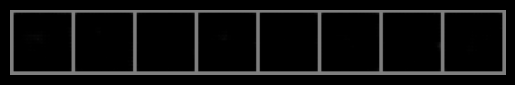

 21%|██        | 21/100 [03:03<11:26,  8.69s/it, discriminator_loss=1.08, generator_loss=1.21]

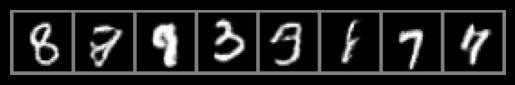

 41%|████      | 41/100 [06:01<08:44,  8.90s/it, discriminator_loss=1.14, generator_loss=1.26]

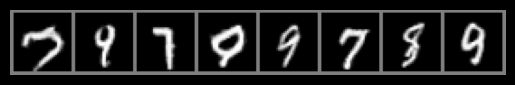

 61%|██████    | 61/100 [08:56<05:33,  8.55s/it, discriminator_loss=1.13, generator_loss=1.4] 

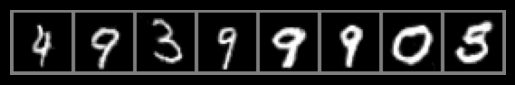

 81%|████████  | 81/100 [11:49<02:45,  8.71s/it, discriminator_loss=1.16, generator_loss=1.32]

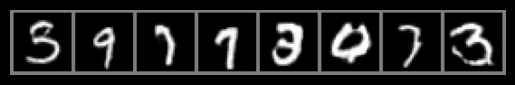

100%|██████████| 100/100 [14:35<00:00,  8.76s/it, discriminator_loss=1.05, generator_loss=1.16]


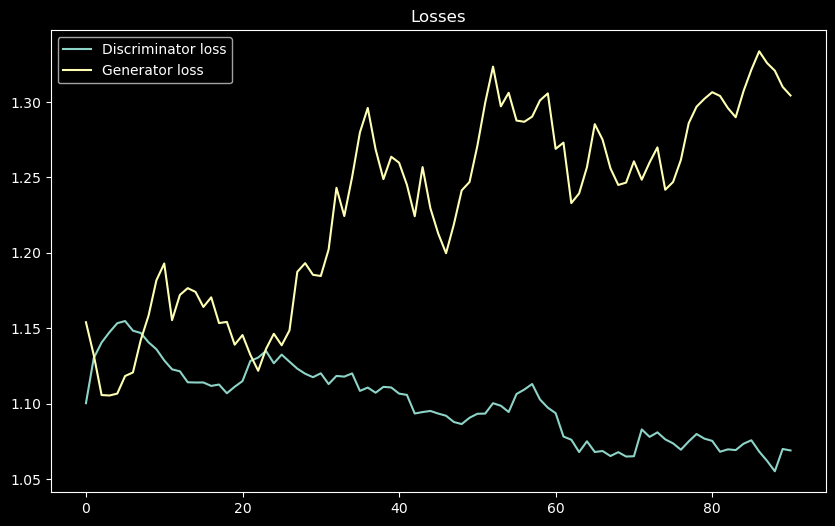

In [15]:
# Hyperparameters
learning_rate_d = 0.0001
learning_rate_g = 0.0001
batch_size = 64
epochs = 100
noise_size = 100  # Dimension of random noise vector for Generator
k = 2  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image

# Create the Discriminator model
discriminator = BaseLineDiscriminator(1, img_size).to(device)
# Create the Generator model
generator = BaseLineGenerator(noise_size, 1, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_mnist_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=20,
)
plot_losses(losses_d, losses_g, do_avg=True, avg_window=10)

#### Results Analysis

##### Overview
After training the Generative Adversarial Network on the MNIST dataset, we generated a set of images to compare with the actual MNIST samples. The aim is to visually assess the quality of the generated images and identify any patterns or discrepancies.

##### Generated Images vs. Real Images

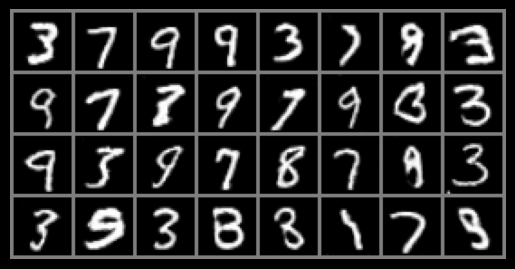

In [16]:
generate_fake_images(generator, noise_size, 32)

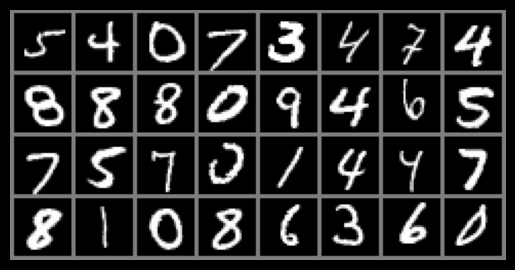

In [17]:
show_sample(mnist_loader)

##### Observations

1. **Quality & Resemblance**: The generated images, at a glance, bear a strong resemblance to the real MNIST samples. The digits in the generated images have distinct shapes and structures.

2. **Mode Collapse**: One observation from the generated samples is a phenomenon known as mode collapse. This is where the generator produces limited varieties of samples, or in some cases, even just one type of sample. In our generated images, there are certain numbers that appear more frequently while others are underrepresented or even missing.

3. **Metrics & Evaluation**: While visual comparison provides insight into the quality of the generated images, there are metrics designed to evaluate the distribution, diversity, and fidelity of generated images, such as the Inception Score or the Frechet Inception Distance. However, the scope of this project is limited to a visual comparison between real and generated images.



##### Comparing with minimax game

In [18]:
def evaluate_discriminator(
    discriminator, generator, real_data_loader, noise_size, device, num_samples=10000
):
    discriminator.eval()  # Set discriminator to evaluation mode
    correct_real, correct_fake, total_real, total_fake = 0, 0, 0, 0

    with torch.no_grad():
        # Evaluate on real images
        for real_images, _ in real_data_loader:
            real_images = real_images.to(device)
            real_preds = discriminator(real_images)
            correct_real += (real_preds > 0.5).sum().item()
            total_real += real_images.size(0)
            if total_real >= num_samples:
                break  # Only evaluate on the specified number of samples

        # Generate fake images and evaluate
        for _ in range(num_samples // batch_size):
            noise = torch.randn(batch_size, noise_size).to(device)
            fake_images = generator(noise)
            fake_preds = discriminator(fake_images)
            correct_fake += (fake_preds < 0.5).sum().item()
            total_fake += batch_size

    # Calculate accuracies
    accuracy_real = correct_real / total_real * 100
    accuracy_fake = correct_fake / total_fake * 100

    return accuracy_real, accuracy_fake

# Usage
accuracy_real, accuracy_fake = evaluate_discriminator(
    discriminator, generator, train_loader, noise_size, device, num_samples=1000
)
print(f"Accuracy on real images: {accuracy_real:.2f}%")
print(f"Accuracy on fake images: {accuracy_fake:.2f}%")

Accuracy on real images: 91.31%
Accuracy on fake images: 78.75%


In a perfect minimax game we would expect the loss of the discriminator to be 0.5, as it would be unable to distinguish between real and fake images. However, in practice, the discriminator is able to distinguish between real and fake images, and the loss is not 0.5. This is because the generator is not able to generate images that are indistinguishable from real images.

That doesn't mean that the generator is not learning. In fact, the generator is able to generate images that are similar to real images, but not identical. This is why the discriminator is able to distinguish between real and fake images, and the loss is not 0.5.

This is one of the reasons why GANs are so hard to train and the visual inspection of the generated images is so important. The loss of the discriminator is not a universal metric to evaluate the performance of a GAN. But is a good indicator of the progress of the training process.

### Fashion MNIST (Baseline)

In this exploration, we venture into training a Generative Adversarial Network (GAN) on the Fashion MNIST dataset, a collection of clothing images belonging to various categories. The process kicks off with the establishment of pivotal hyperparameters including learning rates, batch size, and the total number of epochs. The Discriminator and Generator modules are sculpted using predetermined classes, and the Binary Cross Entropy loss is designated as our chief criterion. The optimizers employed for both the Generator and Discriminator hail from the Adam lineage. As we delve deeper, the Fashion MNIST dataset undergoes meticulous transformations to align with our model's specifications. Upon setting the stage, the GAN training commences, enriched with best practices such as label smoothing and instance noise. In culmination, we cast a spotlight on the loss trends for both the Generator and Discriminator, which unfurl the GAN's evolutionary path and render insights into its progression.


  1%|          | 1/100 [00:08<14:19,  8.69s/it, discriminator_loss=0.991, generator_loss=1.47]

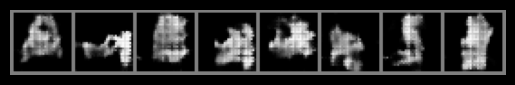

 21%|██        | 21/100 [03:01<11:03,  8.40s/it, discriminator_loss=1.16, generator_loss=0.975]

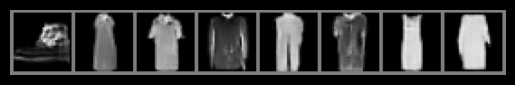

 41%|████      | 41/100 [05:52<08:35,  8.74s/it, discriminator_loss=1.14, generator_loss=0.989]

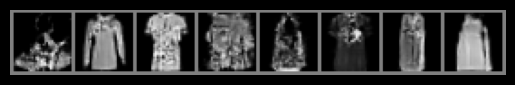

 61%|██████    | 61/100 [08:46<05:36,  8.63s/it, discriminator_loss=1.02, generator_loss=1.16] 

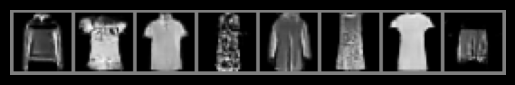

 81%|████████  | 81/100 [11:36<02:41,  8.49s/it, discriminator_loss=1.1, generator_loss=1.06] 

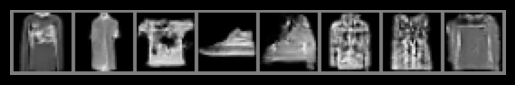

100%|██████████| 100/100 [14:17<00:00,  8.58s/it, discriminator_loss=1.12, generator_loss=1.15]


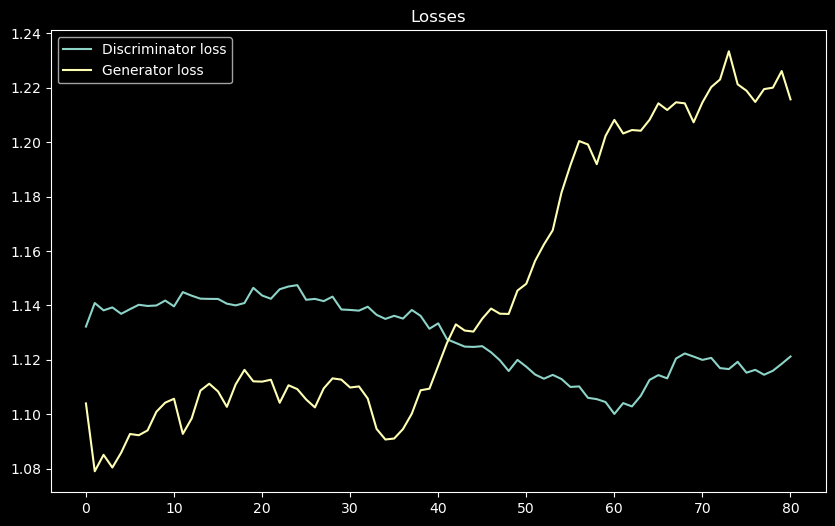

In [19]:
learning_rate_d = 0.0001
learning_rate_g = 0.0001
batch_size = 64
epochs = 100
noise_size = 100  # Dimension of random noise vector for Generator
k = 2  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image

# Create the Discriminator model
discriminator = BaseLineDiscriminator(1, img_size).to(device)
# Create the Generator model
generator = BaseLineGenerator(noise_size, 1, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_fashion_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=20,
)
plot_losses(losses_d, losses_g, True, 20)

#### Results Analysis

##### Generated Images vs. Real Images

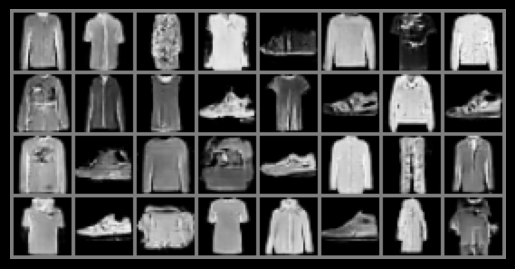

In [20]:
generate_fake_images(generator, noise_size, 32)

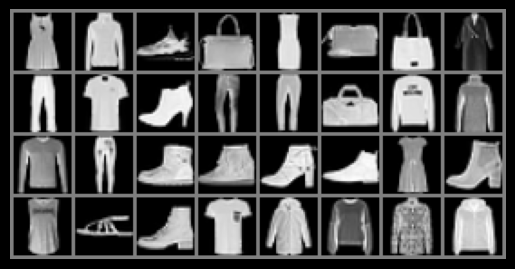

In [21]:
show_sample(train_loader, 32)

##### Observations

1. **Generated Quality:** The generated images from the GAN, although recognizable, exhibit certain noise and lack the sharpness observed in real images.

2. **Item Diversity:** The Generator has managed to produce a diverse set of fashion items, from tops to shoes. This is encouraging as it indicates the Generator isn't stuck on one mode.

3. **Detailing:** Close examination reveals that while the broader shapes are captured, finer details (like patterns on clothes) are either distorted or missing in generated images.

4. **Challenges:** Some generated images show artifacts, hinting that the Generator still has room for improvement. This may be addressed with further training or tweaking.

## Experimentation 1: Exploring Advanced Models

As we continue our journey in the vast world of Generative Adversarial Networks (GANs), we recognize the importance of model architecture in influencing outcomes. While baseline models have provided valuable insights, there's an entire spectrum of advanced architectures waiting to be tapped into.

In this experimentation phase, we set our sights on leveraging more intricate designs for both our Discriminator and Generator. Specifically:

- **Discriminator:** We'll be venturing into the realm of DenseNets. Known for their dense connections, these networks can offer a rich gradient flow, potentially amplifying the power of our Discriminator.

- **Generator:**  Drawing inspiration from residual blocks, this design aims to capture intricate patterns while maintaining a smooth gradient flow.

As we set the stage for these experiments, remember that our focus remains on improving the overall quality and diversity of generated images. It's an exciting phase of exploration, promising new insights and possibilities. Let the experiments begin!

> **Note:** While we are exploring more intricate and complex models, it's essential to understand that complexity doesn't always translate to better results. Each dataset and use-case has its nuances, and sometimes simpler architectures might outperform their complex counterparts. It's all about finding the right balance and fit for the task at hand.



### DenseNet Discriminator Overview

The provided model appears to be a [DenseNet](https://arxiv.org/abs/1608.06993)-based discriminator, typically used within Generative Adversarial Networks (GANs). The architecture can be described at a high level as follows:

#### 1. **ConvLayer**
- This is a basic building block that performs a 2D convolution, followed by a [batch normalization](https://github.com/soumith/ganhacks#4-batchnorm) and a [leaky ReLU activation](https://github.com/soumith/ganhacks#5-avoid-sparse-gradients-relu-maxpool).

#### 2. **DenseBlock**
- The heart of the DenseNet architecture. In this block, the output from each layer is concatenated and used as an input for subsequent layers.
- It consists of multiple `ConvLayer` units.

#### 3. **TransitionLayer**
- This layer is used to downsample the spatial dimensions of the feature maps and to reduce the number of channels.
- It consists of a `ConvLayer` followed by an average pooling operation.

#### 4. **DenseNetDiscriminator**
- The main architecture which houses the entire flow of the network.
- It starts with an initial convolution followed by max pooling.
- Then it consists of a series of `DenseBlock` and `TransitionLayer` units, iterating through dense layers and transition layers.
- Finally, the feature maps are pooled globally, and passed through two fully connected layers to output a single value after the sigmoid activation.

This architecture leverages the power of DenseNet to capture features at various levels and scales for discriminating real from generated images.


In [22]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.leaky_relu(x)
        return x


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(ConvLayer(in_channels + i * growth_rate, growth_rate))

    def forward(self, x):
        outputs = [x]
        for layer in self.layers:
            out = layer(torch.cat(outputs, dim=1))
            outputs.append(out)
        return torch.cat(outputs, dim=1)


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = ConvLayer(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class DenseNetDiscriminator(nn.Module):
    def __init__(self, in_channels, img_size):
        super(DenseNetDiscriminator, self).__init__()
        self.input_size = img_size
        self.init_conv = ConvLayer(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

        self.dense1 = DenseBlock(64, 32, 4)
        self.trans1 = TransitionLayer(192, 96)  # 64 + 4 * 32 = 192 | 192 / 2 = 96
        self.dense2 = DenseBlock(96, 32, 4)
        self.trans2 = TransitionLayer(224, 112)  # 96 + 4 * 32 = 224 | 224 / 2 = 112
        self.dense3 = DenseBlock(112, 32, 4)
        self.trans3 = TransitionLayer(240, 120)  # 112 + 4 * 32 = 240 | 240 / 2 = 120
        self.dense4 = DenseBlock(120, 32, 4)

        self.fc = nn.Linear(248, 512)  # 120 + 4 * 32 = 248
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.pool(x)

        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

### Residual Generator Overview

The architecture presented is a type of generative network that makes use of residual blocks, which have become popular due to their effectiveness in deep learning models, particularly the [ResNet](https://arxiv.org/abs/1512.03385) architecture.

#### 1. **ResidualBlock**
- **Primary Components**: Two convolutional layers, each accompanied by a [batch normalization]((https://github.com/soumith/ganhacks#4-batchnorm)) layer.
- **Function**: Each of the two convolution operations is followed by a batch normalization and a [leaky ReLU activation](https://github.com/soumith/ganhacks#5-avoid-sparse-gradients-relu-maxpool) function. If there's a change in dimensions, a shortcut connection is established to match the output shape.

#### 2. **ResidualGenerator**
- **Initialization**: It calculates the initial dimensions required to match the final image size. A fully connected layer is then used to reshape the input noise vector.
  
- **Deconvolutional Layers**:
  - These layers are used to upscale feature maps.
  - The first deconvolution is followed by a batch normalization and a leaky ReLU activation.
  
- **Residual Block Integration**: After the first deconvolution, a residual block is applied, providing the network an ability to learn identity functions that help in training deeper models.
  
- **Dropout**: This is used after the residual block to prevent overfitting and provide a form of regularization ([link](https://arxiv.org/pdf/1611.07004v1.pdf)).
  
- **Final Layers**: Two more deconvolutional layers are used to further upsample the feature maps. After the final deconvolution, a tanh activation function ensures the output values are between -1 and 1, making it suitable for image data.

The architecture utilizes the power of residual blocks, which helps in avoiding the vanishing gradient problem, thereby allowing for deeper and more effective generative models.


In [23]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer in the residual block
        # Followed by Batch Normalization
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer in the residual block
        # Followed by Batch Normalization
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # Forward pass
        out = F.leaky_relu(self.bn1(self.conv1(x)))  # First Conv -> BN -> ReLU
        out = self.bn2(self.conv2(out))  # Second Conv -> BN
        out += self.shortcut(x)  # Add the shortcut
        out = F.leaky_relu(out)  # Final ReLU
        return out


class ResidualGenerator(nn.Module):
    def __init__(self, noise_size, out_channels, img_size):
        super(ResidualGenerator, self).__init__()

        # Calculate dimensions to back out to the image size
        self.init_height = img_size // 4
        self.init_width = img_size // 4

        # Fully connected layer to reshape the input noise vector
        self.fc = nn.Linear(noise_size, 256 * self.init_height * self.init_width)

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.bn1 = nn.BatchNorm2d(128)

        # Add a Residual Block
        self.res_block = ResidualBlock(128, 128)

        # Add Dropout
        self.dropout = nn.Dropout(0.5)

        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(
            64, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.fc(x)

        x = x.view(
            -1, 256, self.init_height, self.init_width
        )  # Reshape to (batch_size, num_channels, width, height)

        x = self.deconv1(x)
        x = self.bn1(x)  # BatchNorm
        x = F.leaky_relu(x)

        x = self.res_block(x)  # Using Residual Block
        x = self.dropout(x)  # Applying Dropout

        x = self.deconv2(x)
        x = self.bn2(x)  # BatchNorm
        x = F.leaky_relu(x)

        x = self.deconv3(x)
        x = self.bn3(x)

        x = torch.tanh(x)  # output between -1 and 1
        return x

### Mnist (DenseNet Discriminator vs ResNet Generator)

  2%|▏         | 1/50 [00:42<34:52, 42.71s/it, discriminator_loss=1.36, generator_loss=0.711]

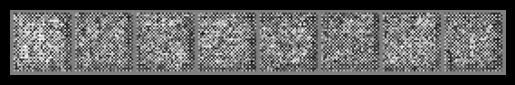

 22%|██▏       | 11/50 [07:43<27:15, 41.93s/it, discriminator_loss=1.14, generator_loss=0.893]

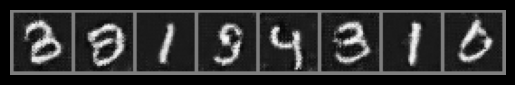

 42%|████▏     | 21/50 [14:43<20:13, 41.84s/it, discriminator_loss=0.871, generator_loss=1.65]

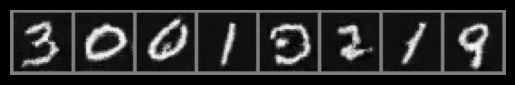

 62%|██████▏   | 31/50 [21:44<13:19, 42.09s/it, discriminator_loss=0.898, generator_loss=1.65]

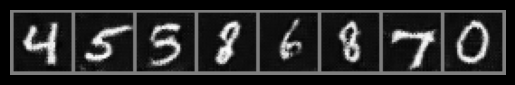

 82%|████████▏ | 41/50 [28:46<06:21, 42.35s/it, discriminator_loss=0.825, generator_loss=1.78]

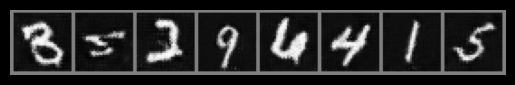

100%|██████████| 50/50 [35:04<00:00, 42.09s/it, discriminator_loss=0.845, generator_loss=1.6] 


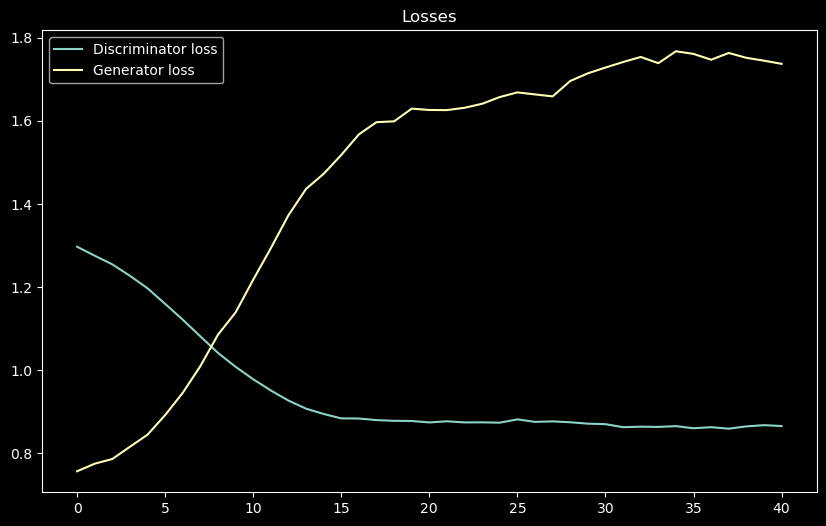

In [24]:
# Hyperparameters
learning_rate_d = 0.00005
learning_rate_g = 0.0001
batch_size = 64
epochs = 50
noise_size = 100  # Dimension of random noise vector for Generator
k = 5  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image

# Create the Discriminator model
discriminator = DenseNetDiscriminator(1, img_size).to(device)
# Create the Generator model
generator = ResidualGenerator(noise_size, 1, img_size).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.SGD(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_mnist_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=10,
)
plot_losses(losses_d, losses_g, True, 10)

#### Observations from Loss Graph

1. **Quick Discriminator Adaptation**: The initial high loss suggests the discriminator's early struggles, but its swift decline indicates rapid learning.
2. **Tug-of-War Dynamics**: Oscillatory losses highlight the ongoing "battle" between the generator and discriminator.
3. **Potential Equilibrium**: The stabilizing losses hint at a near-equilibrium state. However, this could also indicate possible mode collapse or being stuck in a local minimum.

It's vital to inspect generated images alongside loss values for a comprehensive assessment.


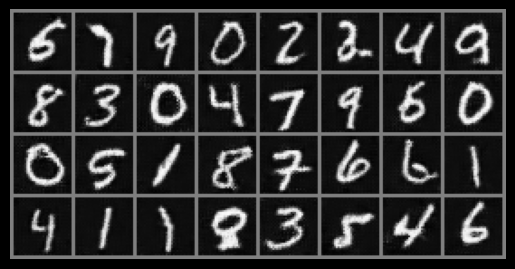

In [25]:
generate_fake_images(generator, noise_size, 32)

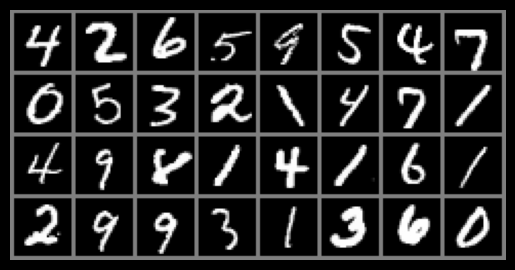

In [26]:
show_sample(mnist_loader)

#### Comments

- **Complex Model Architecture**: Managing both the discriminator and generator was intricate. The nuanced interplay between them presented a substantial training challenge.
- **Sensitive to Hyperparameters**: Even a slight change in the learning rate drastically affected training. In some cases, the generator failed to produce meaningful images after just a few epochs.
- **Stable Training Without Mode Collapse**: The stabilizing losses, combined with the diverse generated images, suggest successful training without the pitfalls of mode collapse.

## Experimentation 2: Conditional GAN (cGAN)

The Conditional Generative Adversarial Network (Conditional GAN or cGAN) extends the traditional GAN framework by adding conditional information to both the generator and discriminator. This approach allows for targeted generation of data based on specific conditions, granting the model a greater degree of control in data synthesis.

In a high-level overview:
- **Purpose**: While standard GANs generate outputs from random noise, cGANs produce outputs based on a given condition or label. This enables the generation of specific types of data.
- **Mechanism**: The generator receives both random noise and a condition label to produce a sample. The discriminator then evaluates the authenticity of the sample based on the combined input of the generated sample and the condition.
- **Applications**: cGANs have broad applications, from generating specific types of images in computer vision tasks to creating particular styles of music or specific textual content.

In essence, Conditional GANs offer a refined approach to data generation, ensuring the generated content aligns more closely with desired attributes or characteristics.


### ConditionalDiscriminator Overview

In essence, the `ConditionalDiscriminator` incorporates the conditioning labels into its architecture, making it capable of discerning not just the authenticity of the image but also its conformity to the given label or condition. On the other hand, the `BaseLineDiscriminator` solely focuses on the authenticity of the image without any conditional context.

In [27]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, in_channels, img_size, num_classes, embedding_size=10):
        super(ConditionalDiscriminator, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # Calculate the output dimension after conv and pooling layers
        self.calc_dim = lambda x: int(((x - 2) // 2 + 1) // 2)
        self.flat_dim = (
            128
            * self.calc_dim(self.calc_dim(img_size))
            * self.calc_dim(self.calc_dim(img_size))
        )

        # Embedding for labels
        self.label_embedding = nn.Embedding(num_classes, embedding_size)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_dim + embedding_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x, labels):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 max pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)  # 2x2 max pooling
        x = x.view(-1, self.flat_dim)  # flatten

        # Embed labels and concatenate with image features
        labels = self.label_embedding(labels)
        x = torch.cat([x, labels], dim=1)

        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # output between 0 and 1
        return x

### ConditionalGenerator Overview

The `ConditionalGenerator` model, like its discriminator counterpart, has been designed to take into account conditioning labels when generating images. This conditioning approach allows for more controlled image generation, catering to specific classes or types based on the input labels. Conversely, the `BaseLineGenerator` lacks this conditioning capability and generates images solely based on the noise input.

By introducing label conditioning into the `ConditionalGenerator`, the generated images can better adhere to specific classes or characteristics defined by the labels, enabling a more targeted and controlled generation process.

In [28]:
class ConditionalGenerator(nn.Module):
    def __init__(
        self, noise_size, out_channels, img_size, num_classes, embedding_size=10
    ):
        super(ConditionalGenerator, self).__init__()

        # Calculate dimensions to back out to the image size
        self.init_height = img_size // 4
        self.init_width = img_size // 4

        # Embedding for labels
        self.label_embedding = nn.Embedding(num_classes, embedding_size)

        # Fully connected layer to reshape the input noise vector
        self.fc = nn.Linear(
            noise_size + embedding_size, 256 * self.init_height * self.init_width
        )  # x2 because of concatenation
        self.dropout = nn.Dropout(0.5)

        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(
            64, out_channels, kernel_size=3, stride=1, padding=1
        )

    def forward(self, z, labels):
        # Embed labels and concatenate with noise
        labels = self.label_embedding(labels)
        z = torch.cat([z, labels], dim=1)

        x = self.fc(z)
        x = x.view(
            -1, 256, self.init_height, self.init_width
        )  # Reshape to (batch_size, num_channels, width, height)
        x = self.dropout(x)
        x = F.leaky_relu(self.deconv1(x))
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.deconv2(x))
        x = self.batch_norm2(x)
        x = torch.tanh(self.deconv3(x))  # output between -1 and 1
        return x

### Conditional GAN Training Process Focus

A Conditional Generative Adversarial Network (CGAN) makes use of additional conditioning information to guide the generation process. This conditioning typically comes in the form of labels. Here's an in-depth look at how conditioning is integrated into the training process you provided:

Both the generator and the discriminator are modified to accept labels, ensuring that the generated images aren't just realistic but also align with the given conditions. This makes CGANs powerful tools for generating images that adhere to specific requirements or classifications.


In [29]:
def generate_conditional_fake_images(
    generator, noise_size, num_classes, number_of_fake_samples=8, specific_label=None
):
    with torch.no_grad():
        # Create a batch of latent vectors (noise)
        noise = torch.randn(number_of_fake_samples, noise_size).to(device)
        # If a specific label is provided, use that. Else, generate random labels.
        if specific_label is not None:
            labels = torch.full(
                (number_of_fake_samples,), specific_label, dtype=torch.long
            ).to(device)
        else:
            labels = torch.randint(0, num_classes, (number_of_fake_samples,)).to(device)
        # Generate images from the latent vector z
        fake_images = generator(noise, labels)

        # Move the tensor from GPU to CPU and detach it from the computation graph
        fake_images = fake_images.cpu().detach()
        grid_images = torchvision.utils.make_grid(fake_images, nrow=8)
        imshow(grid_images)


def train_conditional_discriminator(
    discriminator,
    real_images,
    labels,
    fake_images,
    criterion,
    optimizer_d,
    k,
    batch_size,
    do_smoothing=False,
    do_instance_noise=False,
):
    for _ in range(k):
        # Discriminator training
        optimizer_d.zero_grad()

        if do_instance_noise:
            real_images = add_instance_noise(real_images)
            fake_images = add_instance_noise(fake_images)

        # Real images
        labels_real = torch.ones(real_images.size(0), 1).to(device)
        if do_smoothing:
            labels_real = smooth_positive_labels(labels_real)

        outputs_real = discriminator(real_images, labels)

        loss_real = criterion(outputs_real, labels_real)

        labels_fake = torch.zeros(batch_size, 1).to(device)
        if do_smoothing:
            labels_fake = smooth_negative_labels(labels_fake)

        outputs_fake = discriminator(fake_images.detach(), labels)
        loss_fake = criterion(outputs_fake, labels_fake)

        # Combine losses and update Discriminator
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

    return loss_d


def train_conditional_generator(
    discriminator, fake_images, labels, criterion, optimizer_g, batch_size
):
    # Generator training
    optimizer_g.zero_grad()

    outputs = discriminator(fake_images, labels)
    labels_g = torch.ones(batch_size, 1).to(device)

    # Update Generator
    loss_g = criterion(outputs, labels_g)
    loss_g.backward()
    optimizer_g.step()
    return loss_g


def train_conditional_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    num_classes,
    do_smoothing_label=False,
    do_instance_noise=False,
    log_samples=False,
    log_interval=10,
):
    losses_d = []
    losses_g = []

    # Training loop
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            for _, (real_images, real_labels) in enumerate(train_loader):
                # Move tensors to the device
                real_images = real_images.to(device)
                real_labels = real_labels.to(device)

                noise = torch.randn(batch_size, noise_size).to(device)
                random_labels = torch.randint(0, num_classes, (batch_size,)).to(
                    device
                )  # Random labels for fake images

                fake_images = generator(noise, random_labels).to(device)

                loss_d = train_conditional_discriminator(
                    discriminator,
                    real_images,
                    real_labels,
                    fake_images,
                    criterion,
                    optimizer_d,
                    k,
                    batch_size,
                    do_smoothing=do_smoothing_label,
                    do_instance_noise=do_instance_noise,
                )
                loss_g = train_conditional_generator(
                    discriminator,
                    fake_images,
                    random_labels,
                    criterion,
                    optimizer_g,
                    batch_size,
                )

            pbar.update(1)
            pbar.set_postfix(
                {"discriminator_loss": loss_d.item(), "generator_loss": loss_g.item()},
                refresh=True,
            )

            losses_d.append(loss_d.item())
            losses_g.append(loss_g.item())

            if log_samples and epoch % log_interval == 0:
                generate_conditional_fake_images(generator, noise_size, num_classes)

    return losses_d, losses_g

  0%|          | 1/200 [00:07<25:54,  7.81s/it, discriminator_loss=0.875, generator_loss=1.73]

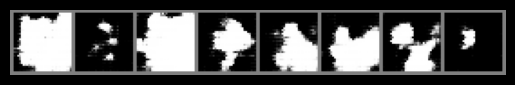

 20%|██        | 41/200 [05:07<20:00,  7.55s/it, discriminator_loss=0.94, generator_loss=0.703] 

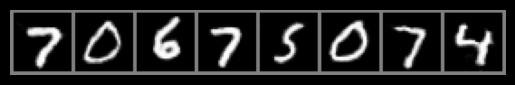

 40%|████      | 81/200 [10:08<15:04,  7.60s/it, discriminator_loss=0.857, generator_loss=0.552]

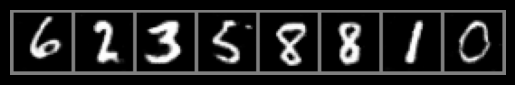

 60%|██████    | 121/200 [15:04<09:31,  7.23s/it, discriminator_loss=0.843, generator_loss=0.798]

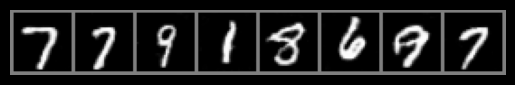

 80%|████████  | 161/200 [19:56<04:43,  7.26s/it, discriminator_loss=0.872, generator_loss=0.708]

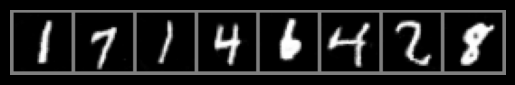

100%|██████████| 200/200 [24:42<00:00,  7.41s/it, discriminator_loss=0.893, generator_loss=1.12] 


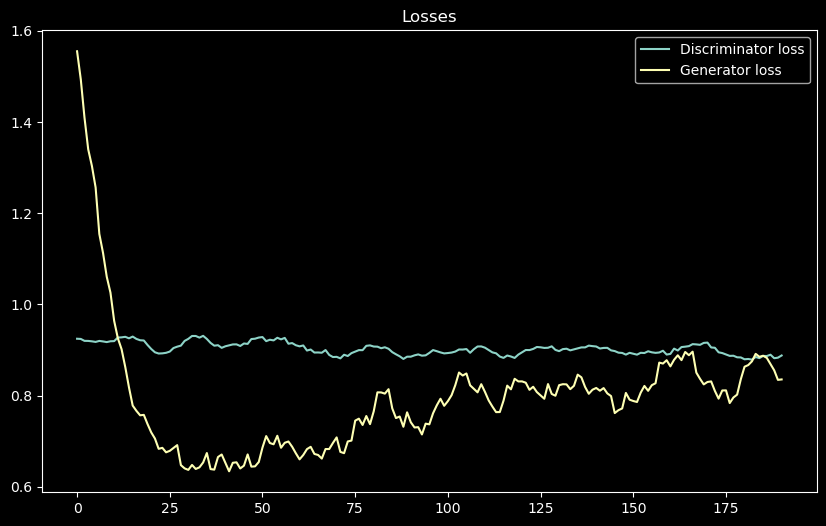

In [30]:
num_classes = 10

# Hyperparameters
learning_rate_d = 0.0003
learning_rate_g = 0.0001
batch_size = 64
epochs = 200
noise_size = 128  # Dimension of random noise vector for Generator
k = 1  # Number of steps to apply to the Discriminator
img_size = 32  # Size of the image
embedding_size = 5  # Size of the embedding for the labels

# Create the Discriminator model
discriminator = ConditionalDiscriminator(1, img_size, num_classes, embedding_size).to(
    device
)
# Create the Generator model
generator = ConditionalGenerator(
    noise_size, 1, img_size, num_classes, embedding_size
).to(device)

# Loss and optimizers
criterion = (
    nn.BCELoss()
)  # Binary cross entropy loss https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g)

# Get the data loader
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_loader = get_mnist_data_loader(transform, batch_size)

# Train the model
losses_d, losses_g = train_conditional_model(
    discriminator,
    generator,
    train_loader,
    criterion,
    optimizer_d,
    optimizer_g,
    epochs,
    k,
    batch_size,
    noise_size,
    num_classes,
    do_smoothing_label=True,
    do_instance_noise=True,
    log_samples=True,
    log_interval=40,
)
plot_losses(losses_d, losses_g, do_avg=True, avg_window=10)

Label: 0


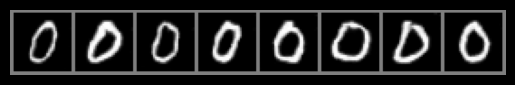

Label: 1


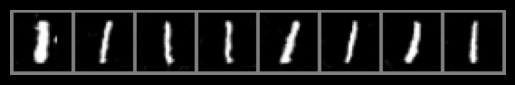

Label: 2


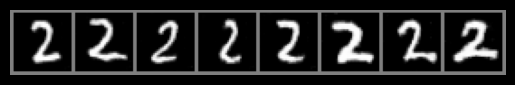

Label: 3


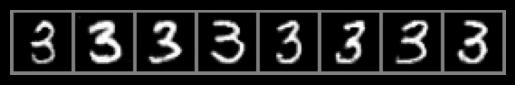

Label: 4


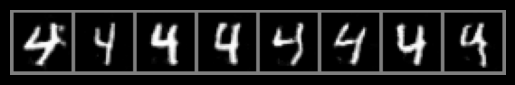

Label: 5


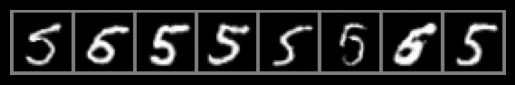

Label: 6


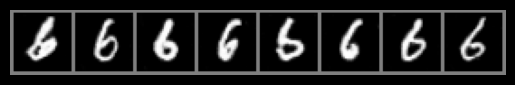

Label: 7


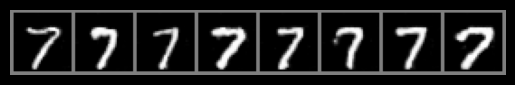

Label: 8


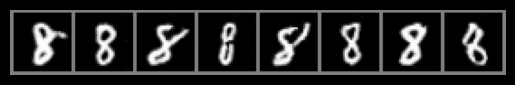

Label: 9


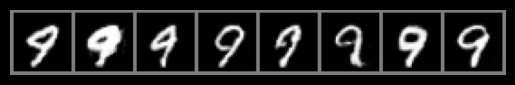

In [31]:
for i in range(num_classes):
    print(f"Label: {i}")
    generate_conditional_fake_images(generator, noise_size, num_classes, 8, i)

We can apriciate that we are able to generate images depending on the label we provide. And the noise give us the ability to generate different images for the same label.

## Reflections on the GAN Journey

### Overview

Working with Generative Adversarial Networks (GANs) has been an enlightening yet challenging journey. Throughout this process, numerous models and hyperparameters were tested, often finding that even minor changes could significantly impact the training outcome. This exploration was not just about tweaking parameters but also about understanding the deeper mechanics and challenges associated with GANs, as highlighted in resources like [Google's Machine Learning GAN Problems](https://developers.google.com/machine-learning/gan/problems).

### Key Learnings

1. **Architectural Variations**: Experimentation with various architectures was crucial. Each architecture brought its own strengths and weaknesses, influencing the quality of the generated images and the stability of training.

2. **Hyperparameter Sensitivity**: GANs demonstrated a high sensitivity to hyperparameter settings. Small modifications often meant the difference between successful training and failure, underscoring the delicate balance required in GAN training.

3. **Community Insights**: Engaging with community experiences and expert articles was invaluable. These resources provided insights and common pitfalls, guiding the experimentation process.

4. **Instability and Challenges**: Consistent with broader experiences in the field, GANs proved to be inherently unstable. Achieving a perfect Nash equilibrium, where both the generator and discriminator are optimally balanced, was almost impossible.

### Achievements

Despite these challenges, significant milestones were achieved. Quality images were generated, demonstrating the successful application of GANs in practical scenarios.

### Future Recommendations

- **Automated Hyperparameter Tuning**: For future GAN projects, consider using tools like Weight and Bias (wandb) for automated hyperparameter search. This can significantly reduce the manual effort and time required in the trial-and-error process.

- **Continued Learning and Experimentation**: The field of GANs is rapidly evolving. Keeping up with the latest research and community developments will be crucial for ongoing success.

- **Balancing Expectations**: It's important to balance the pursuit of theoretical ideals, like the Nash equilibrium, with practical outcomes like image quality and training stability.

### Conclusion

In summary, working with GANs is a journey of continual learning and adaptation. While the pursuit of perfection in terms of a Nash equilibrium remains elusive, the practical achievements in image generation and the insights gained are invaluable. The experience underscores the importance of experimentation, community engagement, and the use of advanced tools for managing complex model training.
